## Importing Libraries
- Copied from the book Hands-On Machine Learning
- Note: Not all code in each cell were copied from the credited site/book

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Titanic"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, constrained_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# copied from StackOverflow
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 100

## Cleaning the Data
- Copied from: https://www.youtube.com/watch?v=pUSi5xexT4Q&list=WL&index=11&t=707s
- The feature engineering part were not copied

In [9]:
# Load the data
# Fill in the missing values, drop the columns that are not needed

import re

my_data = pd.read_csv("train.csv")
my_test_data = pd.read_csv("test.csv")

def clean(data):
    data = data.drop(["Name", "Fare", "Embarked", "Cabin", "Parch", "SibSp"], axis=1)
    
    cols = ["Age"]
    for col in cols:
        data[col].fillna(data[col].mean(), inplace=True)

    # Feature Engineering
    data['Ticket-cat'] = data['Ticket'].str.extract('^([A-Za-z]|[0-9])', expand=False)
    # A variable to represent if the ticket starts with 3 or not
    data['Ticket-bool'] = data['Ticket-cat'].apply(lambda x: 'True' if x == '3' else 'False')
    # A variable to represent if child or not
    data['Child-bool'] = data['Age'].apply(lambda x: 'C' if x <= 6 else 'N')
   # data['Child-bool'] = data['Sex'].apply(lambda x: '2' if x == 'True' else data['Sex'], inplace=True)
    #data['Sex'] = data['Child-bool'].apply(lambda x: 'C' if x == 'True' else pass)
    data['Age-Sex'] = data['Sex'] + data['Child-bool']
    def func(x):
        if x == 'maleN':
            return 'male'
        if x == 'maleC' or x == 'femaleC':
            return 'child'
        if x == 'femaleN':
            return 'female'
    data['Age-Sex-cat'] = data['Age-Sex'].apply(func)
    
    
    data = data.drop(["Ticket", "Ticket-cat", "Sex", "Age", "Age-Sex", "Child-bool"], axis=1)
    data.dropna(inplace=True)
    
    return data

my_data = clean(my_data)
my_test_data = clean(my_test_data)

# transform categorical data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

cols = ["Ticket-bool", 'Age-Sex-cat']

for col in cols:
    my_data[col] = le.fit_transform(my_data[col])
    my_test_data[col] = le.transform(my_test_data[col])
    print(le.classes_)

my_data = my_data.drop(['PassengerId'], axis=1)

['False' 'True']
['child' 'female' 'male']


In [10]:
# Create a copy for Exploratory Analysis
explore_my_data = my_data.copy()

array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Ticket-bool'}>,
        <AxesSubplot:title={'center':'Age-Sex-cat'}>]], dtype=object)

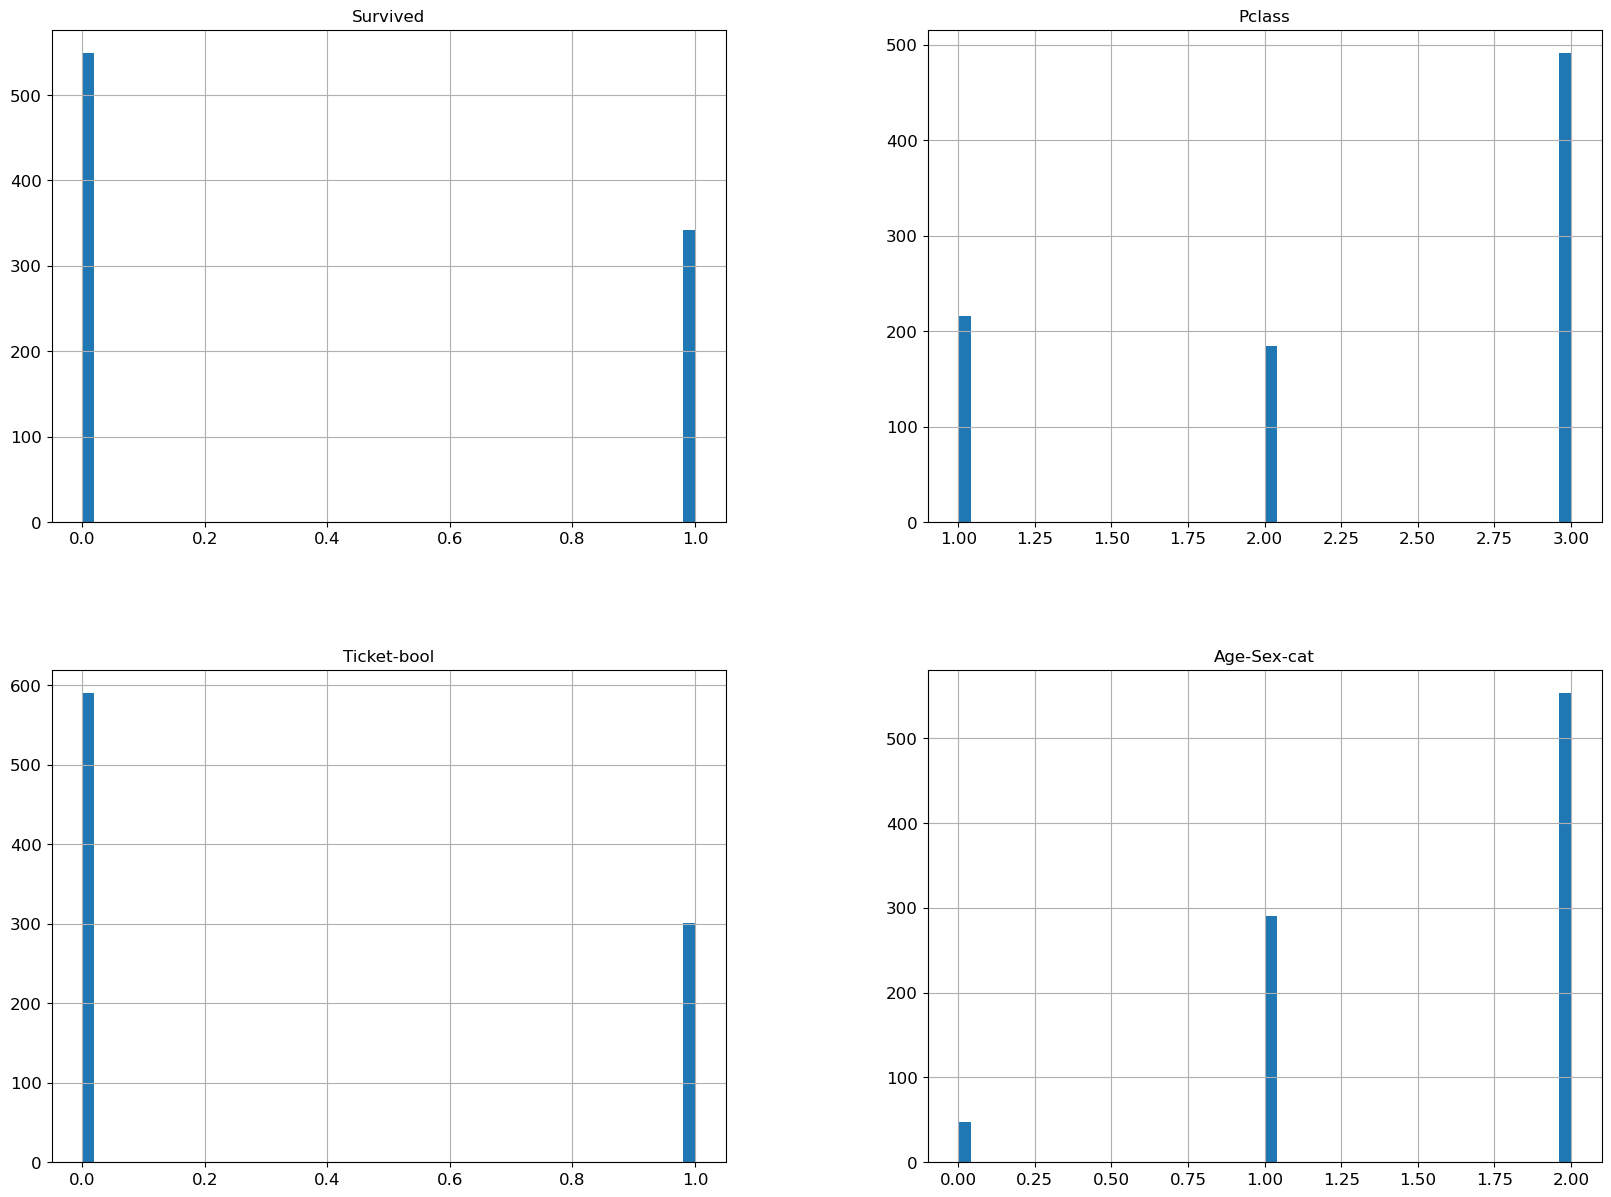

In [11]:
explore_my_data.hist(bins=50, figsize=(20,15))

In [12]:
# Measure correlation of each variable
# copied from Hands-On Machine Learning book
# Used to see which variables are promising

corr_matrix = explore_my_data.corr()
print(corr_matrix["Survived"].sort_values(ascending=False))

Survived       1.000000
Ticket-bool   -0.212428
Pclass        -0.338481
Age-Sex-cat   -0.522926
Name: Survived, dtype: float64


## Exploratory Data Analysis - Count Plots

<AxesSubplot:xlabel='Age-Sex-cat', ylabel='count'>

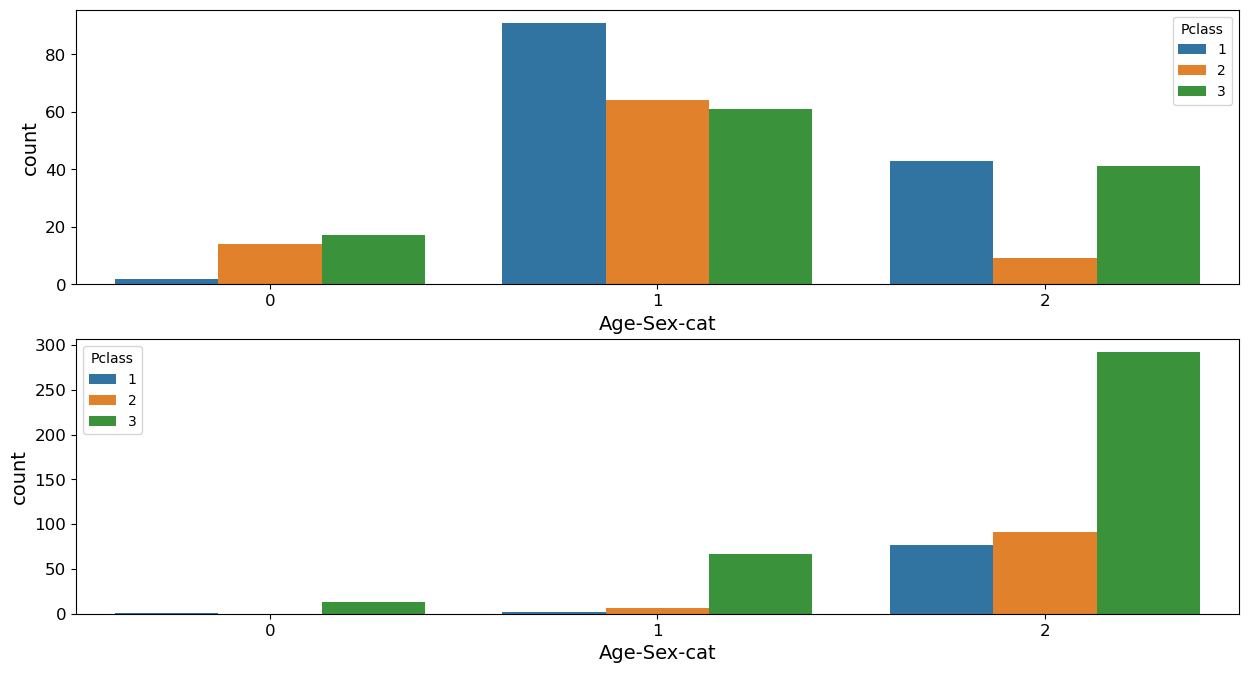

In [13]:
# DATA EXPLORATION

df = explore_my_data
sorted_data = df.sort_values("Survived")

# explore_my_data['Survived'].value_counts()

did_not_survive, survived = train_test_split(sorted_data, test_size=0.383, shuffle=False)

# survived['Survived'].value_counts()

fig, axes = plt.subplots(2,1)

sns.countplot(x = 'Age-Sex-cat', data = survived, hue = 'Pclass', ax=axes[0])
sns.countplot(x = 'Age-Sex-cat', data = did_not_survive, hue = 'Pclass', ax=axes[1])

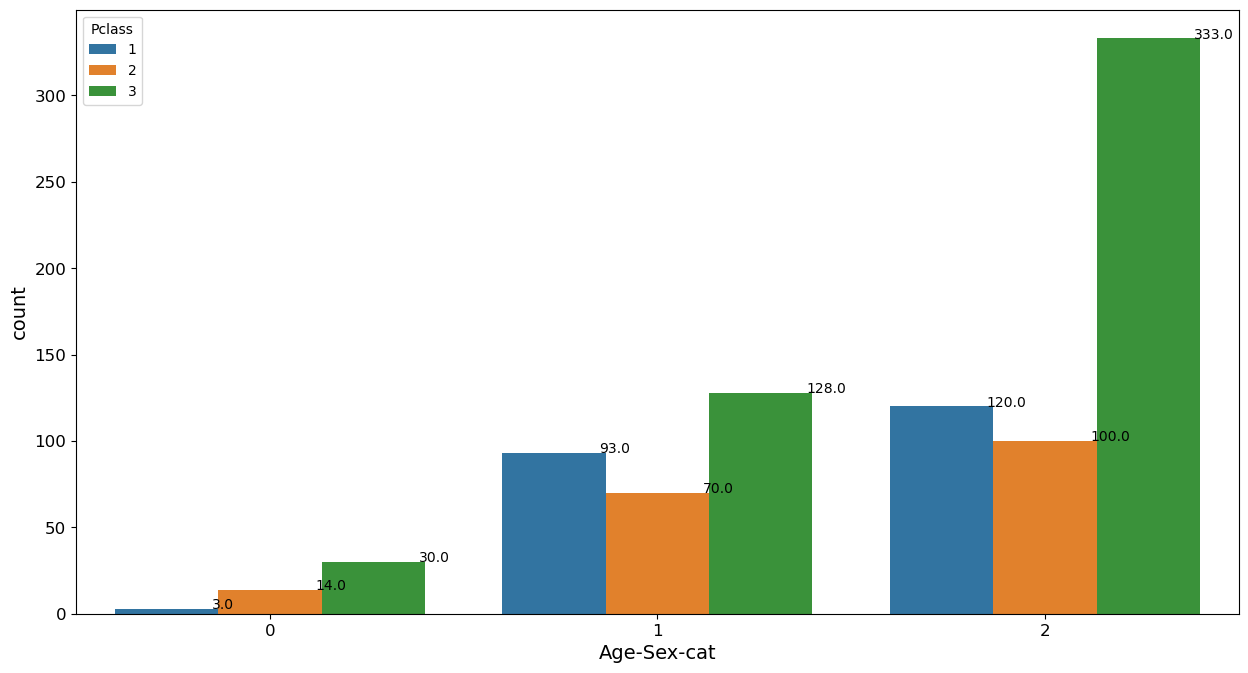

In [14]:
# DATA EXPLORATION WITH COUNT

ax = sns.countplot(x = 'Age-Sex-cat', data = explore_my_data, hue = 'Pclass')

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

## Trying out different models
*Code for all model selection, fine tuning, and measuring performance were copied from "outcompete" https://www.youtube.com/watch?v=j4XvJEbaVJg&list=WL&index=6*

In [15]:
# Separate a validation set - to be used when cross validating my algorithms
# copied from Hands-On Machine Learning Book

my_data_train, my_data_val = train_test_split(my_data, test_size=0.2, random_state=42)

In [16]:
X = my_data.drop("Survived", axis=1)
y = my_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Support Vector Machine

In [17]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)

predictions = svm.predict(X_test)

In [18]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88        57
           1       0.85      0.67      0.75        33

    accuracy                           0.83        90
   macro avg       0.84      0.80      0.81        90
weighted avg       0.83      0.83      0.83        90

[[53  4]
 [11 22]]


In [19]:
# fine-tune the model using GridSearch

from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.5,1,10,50,100,1000], 'gamma':[1,0.1,0.001,0.0001,0.00001,0.000001]}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)

grid.fit(X_train, y_train)
grid_predictions = grid.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .....................................C=0.5, gamma=1; total time=   0.0s
[CV] END .....................................C=0.5, gamma=1; total time=   0.0s
[CV] END .....................................C=0.5, gamma=1; total time=   0.0s
[CV] END .....................................C=0.5, gamma=1; total time=   0.0s
[CV] END .....................................C=0.5, gamma=1; total time=   0.0s
[CV] END ...................................C=0.5, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.5, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.5, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.5, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.5, gamma=0.1; total time=   0.0s
[CV] END .................................C=0.5, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.5

[CV] END ..................................C=50, gamma=0.001; total time=   0.0s
[CV] END .................................C=50, gamma=0.0001; total time=   0.0s
[CV] END .................................C=50, gamma=0.0001; total time=   0.0s
[CV] END .................................C=50, gamma=0.0001; total time=   0.0s
[CV] END .................................C=50, gamma=0.0001; total time=   0.0s
[CV] END .................................C=50, gamma=0.0001; total time=   0.0s
[CV] END ..................................C=50, gamma=1e-05; total time=   0.0s
[CV] END ..................................C=50, gamma=1e-05; total time=   0.0s
[CV] END ..................................C=50, gamma=1e-05; total time=   0.0s
[CV] END ..................................C=50, gamma=1e-05; total time=   0.0s
[CV] END ..................................C=50, gamma=1e-05; total time=   0.0s
[CV] END ..................................C=50, gamma=1e-06; total time=   0.0s
[CV] END ...................

In [20]:
print(classification_report(y_test, grid_predictions))
print(confusion_matrix(y_test, grid_predictions))

# Through feature engineering we can get better scores

              precision    recall  f1-score   support

           0       0.92      0.81      0.86        57
           1       0.72      0.88      0.79        33

    accuracy                           0.83        90
   macro avg       0.82      0.84      0.83        90
weighted avg       0.85      0.83      0.84        90

[[46 11]
 [ 4 29]]


### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)

print(classification_report(y_test, lr_predictions))
print(confusion_matrix(y_test, lr_predictions))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85        57
           1       0.77      0.70      0.73        33

    accuracy                           0.81        90
   macro avg       0.80      0.79      0.79        90
weighted avg       0.81      0.81      0.81        90

[[50  7]
 [10 23]]


### k Neighbors Classifier

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# fine tuning kneighbors
error_list = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    knn_predictions = knn.predict(X_test)
    error_list.append(np.mean(knn_predictions != y_test))
    
np.argmin(error_list)

0

In [23]:
# applying kneighbors

knn = KNeighborsClassifier(n_neighbors=26)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)

print(classification_report(y_test, knn_predictions))
print(confusion_matrix(y_test, knn_predictions))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90        57
           1       0.96      0.67      0.79        33

    accuracy                           0.87        90
   macro avg       0.90      0.82      0.84        90
weighted avg       0.88      0.87      0.86        90

[[56  1]
 [11 22]]


### Decision Tree Classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_predictions = dt.predict(X_test)

# Decision Tree Classifier

print(classification_report(y_test, dt_predictions))
print(confusion_matrix(y_test, dt_predictions))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        57
           1       0.85      0.85      0.85        33

    accuracy                           0.89        90
   macro avg       0.88      0.88      0.88        90
weighted avg       0.89      0.89      0.89        90

[[52  5]
 [ 5 28]]


### Random Forest Classifer

In [25]:
# Random Forest Classifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)

print(classification_report(y_test, rfc_predictions))
print(confusion_matrix(y_test, rfc_predictions))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        57
           1       0.85      0.85      0.85        33

    accuracy                           0.89        90
   macro avg       0.88      0.88      0.88        90
weighted avg       0.89      0.89      0.89        90

[[52  5]
 [ 5 28]]


## Predictions on the test set using Logistic Regression

In [29]:
no_ID = my_test_data.drop(['PassengerId'], axis=1)
my_test_data['Survived'] = lr.predict(no_ID)
my_test_data = my_test_data.drop(["Pclass","Ticket-bool","Age-Sex-cat"], axis=1)
my_test_data['Survived'].value_counts()

0    301
1    117
Name: Survived, dtype: int64

In [30]:
my_test_data.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


## REFERENCES:

- Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélien Géron (O’Reilly). Copyright 2017 Aurélien Géron, 978-1-491-96229-9.
- outcompete. (2020). Python Machine Learning Tutorial #1: The Titanic Dataset from Kaggle. YouTube. https://www.youtube.com/watch?v=j4XvJEbaVJg&amp;t=10.
- Aladdin Persson. (2021). How to do the Titanic Kaggle Competition. Youtube. https://www.youtube.com/watch?v=pUSi5xexT4Q&t=710s